# Simple *airing* use case example

## 0. Necessary imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import corner
import ptemcee
import h5py
import os
import time

## 1. Generation of toy data

Consider a sine wave of amplitude $A$ and frequency $f_0$ buried into white Gaussian noise.

In [2]:
# Amplitude
a = 2.0
# Frequency
f_0 = 0.12156
# Phase
phi_0 = 0.0
# Observation duration
t_obs = 200
# Sampling frequency
f_s = 2.0
# Data size
size = int(f_s * t_obs)
# Noise standard deviation
sigma = 2.0
# Time vector
t = np.arange(0, size) / f_s
# Signal
wave = a * np.sin(2*np.pi*f_0*t + phi_0)
# Noise
noise = np.random.normal(loc=0, scale=sigma, size=size)
# Observed data
dat = wave + noise

In [3]:
# Check the signal-to-noise ratio
dat_dft = np.fft.fft(dat)
wav_dft = np.fft.fft(wave)
dat_dft_norm = dat_dft * 2 / size
wav_dft_norm = wav_dft * 2 / size
freq = np.fft.fftfreq(size) * f_s

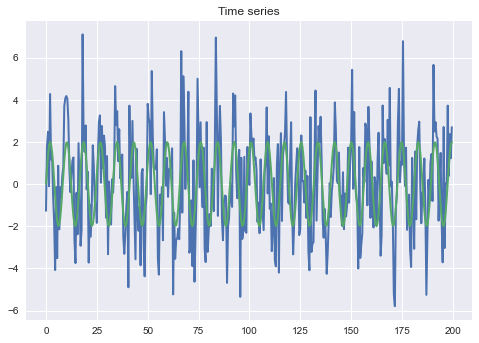

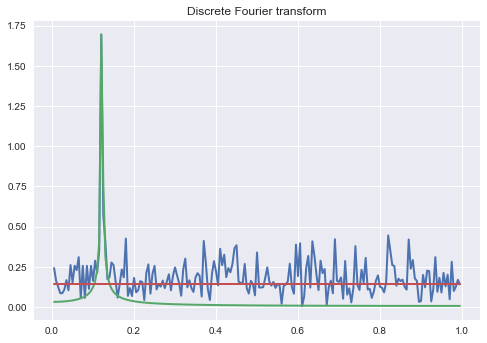

In [4]:

# Visualization
plt.style.use('seaborn')
# plot
fig, ax = plt.subplots()
ax.set_title("Time series")
ax.plot(t, dat, linewidth=2, label='data')
ax.plot(t, wave, linewidth=2, label='signal')
plt.show()

fig, ax = plt.subplots()
ax.set_title("Discrete Fourier transform")
ax.plot(freq[freq>0], np.abs(dat_dft_norm[freq>0]), linewidth=2, label='data')
ax.plot(freq[freq>0], np.abs(wav_dft_norm[freq>0]), linewidth=2, label='signal')
ax.plot(freq[freq>0], np.ones(size)[freq>0] * sigma * np.sqrt(2 / size), linewidth=2, label='noise level')
plt.show()


In [5]:
print(freq[1])
print(a)
print(f_0)

0.005
2.0
0.12156


## 2. Definition of the model likelihood

We need to define a model likelihood that distinguishes between to kinds of parameters. Here, the frequency parameter (which appears non-linearly in the signal) is referred to as the intrinsic parameter. The amplitude of the wave is the extrinsic parameter. We assume a Gaussian likelihood:

$p(y | A , f_0) = {N}\left(A\sin(2\pi f_0 t + \phi_0), \sigma^{2}\right)$

In [6]:
# Define a Gaussian likelihood
class GaussianLikelihood:

    def __init__(self, time, data, sigma, phi_0=phi_0):

        self.time = time
        self.fs = 1 / (time[1] - time[0])
        self.data = data
        self.sigma = sigma
        self.phi_0 = phi_0
        self.size = data.shape[0]
        self.norm = - self.size / 2 * np.log(2 * np.pi)
        # self.data_dft = dat_dft * np.sqrt(2 / (self.fs*self.size))
        # self.sigma_dft = self.sigma * np.sqrt(2/self.fs)
        
    def loglike(self, params):

        frequency = params[0]
        amplitude = params[1]

        mu = amplitude * np.sin(2*np.pi*frequency*self.time + self.phi_0)

        return - 0.5 * np.sum(np.abs(self.data - mu)**2 / self.sigma**2) + self.norm

In [7]:
# Instantiate the likelihood
ll_cls = GaussianLikelihood(t, dat, sigma, phi_0=phi_0)
# Test likelihood
print(ll_cls.loglike([f_0, a]))

-558.8796744203498


In [8]:
print(1/t_obs)

0.005


In [9]:
df_vect = np.arange(f_0 - 5/ t_obs, f_0 + 5 / t_obs, 0.0001)
ll_values_f= np.array([ll_cls.loglike(np.concatenate([[df], [a]])) for df in df_vect])
i_max = np.argmax(ll_values_f)

No handles with labels found to put in legend.


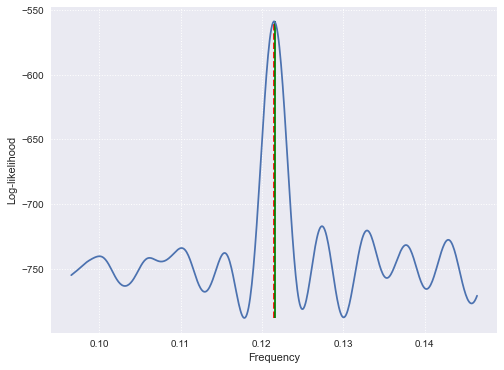

In [10]:
fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(df_vect, ll_values_f, marker='+')
ax.legend(loc='upper left')
ax.vlines(df_vect[i_max], 
          np.min(ll_values_f), 
          ll_values_f[i_max], 
          color='red', 
          linestyle='dashed')
ax.vlines(f_0, 
np.min(ll_values_f), 
ll_cls.loglike(np.concatenate([[f_0], [a]])), 
color='green', 
linestyle='solid')
ax.set_xlabel(r"Frequency")
ax.set_ylabel("Log-likelihood")
ax.grid(linestyle='dotted')
plt.show()

## 3. Definition of the prior

In [11]:
# We need a Gaussian prior
def logp(x, low_f, high_f, mu_0, sigma_0):
    # Uniform prior for the frequency
    if (x[0] >= low_f) & (x[0] <= high_f):
        # Gaussian prior for the amplitude
        return - 0.5 * np.sum(((x-mu_0)/sigma_0)**2)
    else:
        return - np.inf

# Define the prior bounds for all parameters (frequency, amplitude)
low_f = 1 / t_obs # f_0 - 5 / t_obs
high_f = f_s / 2 # f_0 + 5 / t_obs
lower_bounds =  np.array([low_f, -10.0])
upper_bounds = np.array([high_f, 10.0])
mu_0 = 0
sigma_0 = (upper_bounds[1] - lower_bounds[1]) / 3
print(sigma_0)
print(lower_bounds)
print(upper_bounds)

6.666666666666667
[ 5.e-03 -1.e+01]
[ 1. 10.]


## 4. Run a classic sampler

In [12]:
nwalkers = 100
ndim = 2
ndim1 = 1
ndim2 = 1
ntemps = 4

# Initialize all parameters
p_0 = np.random.uniform(lower_bounds, upper_bounds, size=(ntemps, nwalkers, ndim))

In [13]:
# Instantiate the sampler
sampler = ptemcee.Sampler(nwalkers, ndim, ll_cls.loglike, logp, 
                          logpargs=[low_f, high_f, mu_0, sigma_0], 
                          ntemps=ntemps)


In [14]:
n_iter = 1000
n_thin = 1
result = sampler.run_mcmc(p_0[:], iterations=n_iter, thin=n_thin)

In [15]:
sampler.chain.shape

(4, 100, 1000, 2)

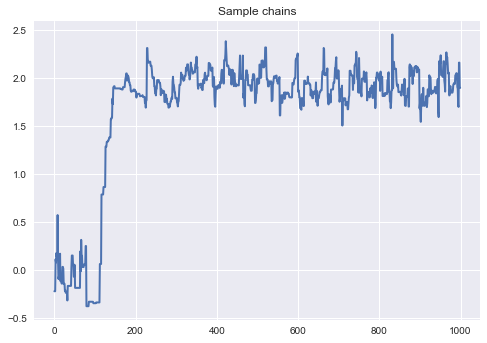

In [16]:
# check the chains
fig, ax = plt.subplots()
ax.set_title("Sample chains")
ax.plot(sampler._chain[0, 0, :, 1], linewidth=2, label='chain')
plt.show()

In [17]:
burnin = 500
samples_plot = sampler._chain[0, :, burnin:, :].reshape((nwalkers*(sampler._chain.shape[2]-burnin), sampler._chain.shape[-1]))

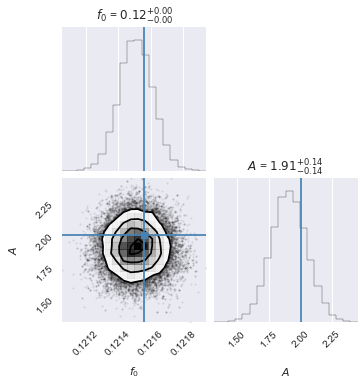

In [18]:
# Plot it.
figure = corner.corner(samples_plot, labels=[r"$f_0$", r"$A$"],
                       show_titles=True, 
                       truths=[f_0, a],
                       title_kwargs={"fontsize": 12})

## 5. Run a MCMC and save the results along the way


In [19]:
class HDF5Store(object):
    """
    Simple class to append value to a hdf5 file on disc (usefull for building keras datasets)
    
    Params:
        datapath: filepath of h5 file
        dataset: dataset name within the file
        shape: dataset shape (not counting main/batch axis)
        dtype: numpy dtype
    
    Usage:
        hdf5_store = HDF5Store('/tmp/hdf5_store.h5','X', shape=(20,20,3))
        x = np.random.random(hdf5_store.shape)
        hdf5_store.append(x)
        hdf5_store.append(x)
        
    From https://gist.github.com/wassname/a0a75f133831eed1113d052c67cf8633
    """
    def __init__(self, datapath, dataset, shape, dtype=np.float32, 
                 compression="gzip", chunk_len=1):
        self.datapath = datapath
        self.dataset = dataset
        self.shape = shape
        self.i = 0

        # Create the file if it does not already exists
        if not os.path.isfile(self.datapath):
            with h5py.File(self.datapath, mode='w') as h5f:
                self.dset = h5f.create_dataset(
                    dataset,
                    shape=(0, ) + shape,
                    maxshape=(None, ) + shape,
                    dtype=dtype,
                    compression=compression,
                    chunks=(chunk_len, ) + shape)
    
    def append(self, values):
        """
        Append more value to dataset.
        
        Parameters
        ----------
        values : ndarray
            Array of values to append. Should have shape (n_values, shape)
        
        """
        with h5py.File(self.datapath, mode='a') as h5f:
            dset = h5f[self.dataset]
            values_shape = np.shape(values)
            
            # Check that the number of dimensions is the same
            if len(values_shape) == len(self.shape):
                n_values = 1
            # If it's not, there is more than one value to add
            elif len(values_shape) > len(self.shape):
                n_values = values_shape[0]
            else:
                raise ValueError("There is a dimension problem.")
            dset.resize((self.i + n_values, ) + self.shape)
            dset[-n_values:] = [values]
            self.i += n_values
                
            h5f.flush()

    def load(self):
        with h5py.File(self.datapath, mode='r') as h5f:
            dset = h5f[self.dataset][()]
        return dset    

    @staticmethod
    def chain_to_save(chain):
        ntemps, nwalkers, nsteps, ndim = np.shape(chain)
        reshaped_chain = np.zeros((nsteps, ntemps, nwalkers, ndim))
        for i in range(nsteps):
            reshaped_chain[i, :, :, :] = chain[:, :, i, :]
        
        return reshaped_chain
    
    @staticmethod
    def save_to_chain(reshaped_chain):

        nsteps, ntemps, nwalkers, ndim = np.shape(reshaped_chain)
        chain = np.zeros((ntemps, nwalkers, nsteps, ndim))
        for i in range(nsteps):
            chain[:, :, i, :] = reshaped_chain[i, :, :, :]
        
        return chain

In [32]:
# Instantiate the sampler
sampler = ptemcee.Sampler(nwalkers, ndim, ll_cls.loglike, logp, 
                          logpargs=[low_f, high_f, mu_0, sigma_0], 
                          ntemps=ntemps)

In [33]:
# Number of iterations
n_iter = 1000
n_thin = 1
# Save results every 100 samples
n_save = 100
# Print progress every 200 samples
n_verbose = 200

# Initialize parameter state
pos = p_0[:]
# Initialize iteration counter
i = 0
isave = 0

output_dir = "../data/"
chain_suffix = "mychains.h5"
# logl_suffix = "mylogl.h5"
# logp_suffix = "mylogp.h5"

hdf5 = HDF5Store(output_dir + chain_suffix, 
                 "chains", 
                 np.shape(p_0), 
                 dtype=float, 
                 compression="gzip", 
                 chunk_len=1)

# Block of chain to be saved
nsize = np.min([n_save, n_iter])
chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
logl_save = np.zeros((ntemps, nwalkers, nsize))
logp_save = np.zeros((ntemps, nwalkers, nsize))
t1 = time.time()
for pstate, lnlike0, lnprob0 in sampler.sample(pos, n_iter, thin=n_thin, storechain=True):

    # Store data
    chain_save[:, :, isave, :] = pstate
    logl_save[:, :, isave] = lnlike0
    logp_save[:, :, isave] = lnprob0

    if isave == n_save - 1:
        # If the number of iterations in a multiple of n_save
        print("Save data at iteration " + str(i) + "...")
        # The number of saved iterations at iteration i is
        # saved_it = i // thin
        # ------Samples---------

        hdf5.append(hdf5.chain_to_save(chain_save))
        # ------Log likelihood---------
        # ------Log prior---------
        print("Data saved.")
        # Update the number of samples saved
        isave += nsize
        # Once data is saved, re-initialize the arrays
        nsize = np.min([n_save, n_iter-i])
        chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
        logl_save = np.zeros((ntemps, nwalkers, nsize))
        logp_save = np.zeros((ntemps, nwalkers, nsize))
        # Set the saving counter to zero
        isave = 0
    else:
        # increment saving counter
        isave += 1
    
    if i % (n_verbose -1) == 0:
        print("Iteration " + str(i) + " completed.")
    # Increment global counter
    i += 1


t2 = time.time()
print(t2-t1)

Iteration 1 completed.
Save data at iteration 99...
Data saved.
Save data at iteration 199...
Data saved.
Iteration 201 completed.
Save data at iteration 299...
Data saved.
Save data at iteration 399...
Data saved.
Iteration 401 completed.
Save data at iteration 499...
Data saved.
Save data at iteration 599...
Data saved.
Iteration 601 completed.
Save data at iteration 699...
Data saved.
Save data at iteration 799...
Data saved.
Iteration 801 completed.
Save data at iteration 899...
Data saved.
Save data at iteration 999...
Data saved.
11.997713327407837


In [34]:
chains = hdf5.save_to_chain(hdf5.load())

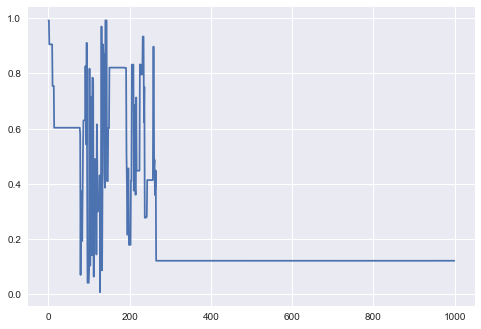

In [35]:
plt.figure(0)
plt.plot(chains[0, 0, :, 0])
plt.show()

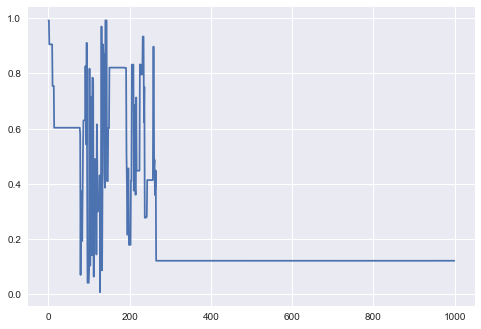

In [36]:
plt.figure(0)
plt.plot(sampler.chain[0, 0, :, 0])
plt.show()

## 6. Using multithreading

In [25]:
# from multiprocessing import Pool
# import os
# import time
# # Needs to disable numpy internal multithreading 
# # as it does not get along well with multiprocessing
# os.environ["OMP_NUM_THREADS"] = "1"
# # pool = None

# t1 = time.time()
# with Pool() as pool:
#     sampler = ptemcee.Sampler(nwalkers, ndim, ll_cls.loglike, logp, 
#                              logpargs=[low_f, high_f, mu_0, sigma_0], 
#                              ntemps=ntemps,
#                              pool=pool)
#     # Number of iterations
#     n_iter = 1000
#     n_thin = 1
#     pos = p_0[:]
#     for pstate, lnlike0, lnprob0 in sampler.sample(p_0, n_iter, thin=n_thin, storechain=False):
#         pass
#     # sampler.run_mcmc(p_0, n_iter, n_thin)
# t2 = time.time()
# print(t2-t1)